import des librairies et fonctions utiles au projet 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import sklearn
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import neighbors, metrics
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor


Ouverture des fichiers de données météo et données de consommation 



In [4]:
cons = pd.read_csv("df_vst_group8.csv",decimal='.')
cork = pd.read_csv("Corkstation_15072019_01022011.csv",nrows=12432,decimal='.')
donnees = pd.merge(cons,cork)

# Extraction de l'heure, des jours, jours de semaines, mois et années dans des colonnes séparées
donnees['date'] = pd.to_datetime(donnees['date'])
donnees['Heure'] = donnees['date'].dt.time.apply(lambda x: x.hour)
donnees['jour'] = donnees['date'].dt.date
donnees['weekday'] = donnees['date'].dt.weekday
donnees['month']= donnees['date'].dt.month
donnees['year'] = donnees['date'].dt.year


# Calcul de la température moyenne par jour et remplacement des valeurs de température par la température moyenne
temperature_moyenne = donnees.groupby('jour')['temp'].mean().reset_index()
temperature_moyenne = temperature_moyenne.rename(columns={'temp': 'temp_moyenne'})
donnees_merged = pd.merge(donnees, temperature_moyenne, on='jour')
donnees_merged['temp'] = donnees_merged['temp_moyenne']
donnees_merged = donnees_merged.drop([ 'temp_moyenne'], axis=1)

donnees = donnees_merged

#donnees contient les éléments de consommation et météo classés par date jusqu'au 14/12/2010
print(donnees)



                     date      mean       temp  ind  rain  ind.1  ind.2  wetb   
0     2009-07-15 00:00:00  0.359623  14.954167    3   0.0      0      0  11.4  \
1     2009-07-15 01:00:00  0.246548  14.954167    3   0.0      0      0  11.1   
2     2009-07-15 02:00:00  0.194699  14.954167    3   0.1      0      0  10.9   
3     2009-07-15 03:00:00  0.180482  14.954167    3   0.0      0      0  10.8   
4     2009-07-15 04:00:00  0.168851  14.954167    3   0.0      0      0  11.1   
...                   ...       ...        ...  ...   ...    ...    ...   ...   
12427 2010-12-14 19:00:00  1.047525   3.358333    3   0.0      0      0   1.1   
12428 2010-12-14 20:00:00  1.000873   3.358333    3   0.0      0      0   0.4   
12429 2010-12-14 21:00:00  0.948643   3.358333    3   0.0      0      1  -0.3   
12430 2010-12-14 22:00:00  0.837083   3.358333    3   0.0      1      1  -0.4   
12431 2010-12-14 23:00:00  0.699087   3.358333    3   0.0      0      1  -0.2   

       dewpt  vappr  ...   

# Tracer de la consommation moyenne par jour en fonction de plusieurs attributs afin de déterminer lesquels nous prendrons dans notre modèle.



Consommation en fonction du jour de la semaine.



Text(0, 0.5, 'consommation moyenne(kWh)')

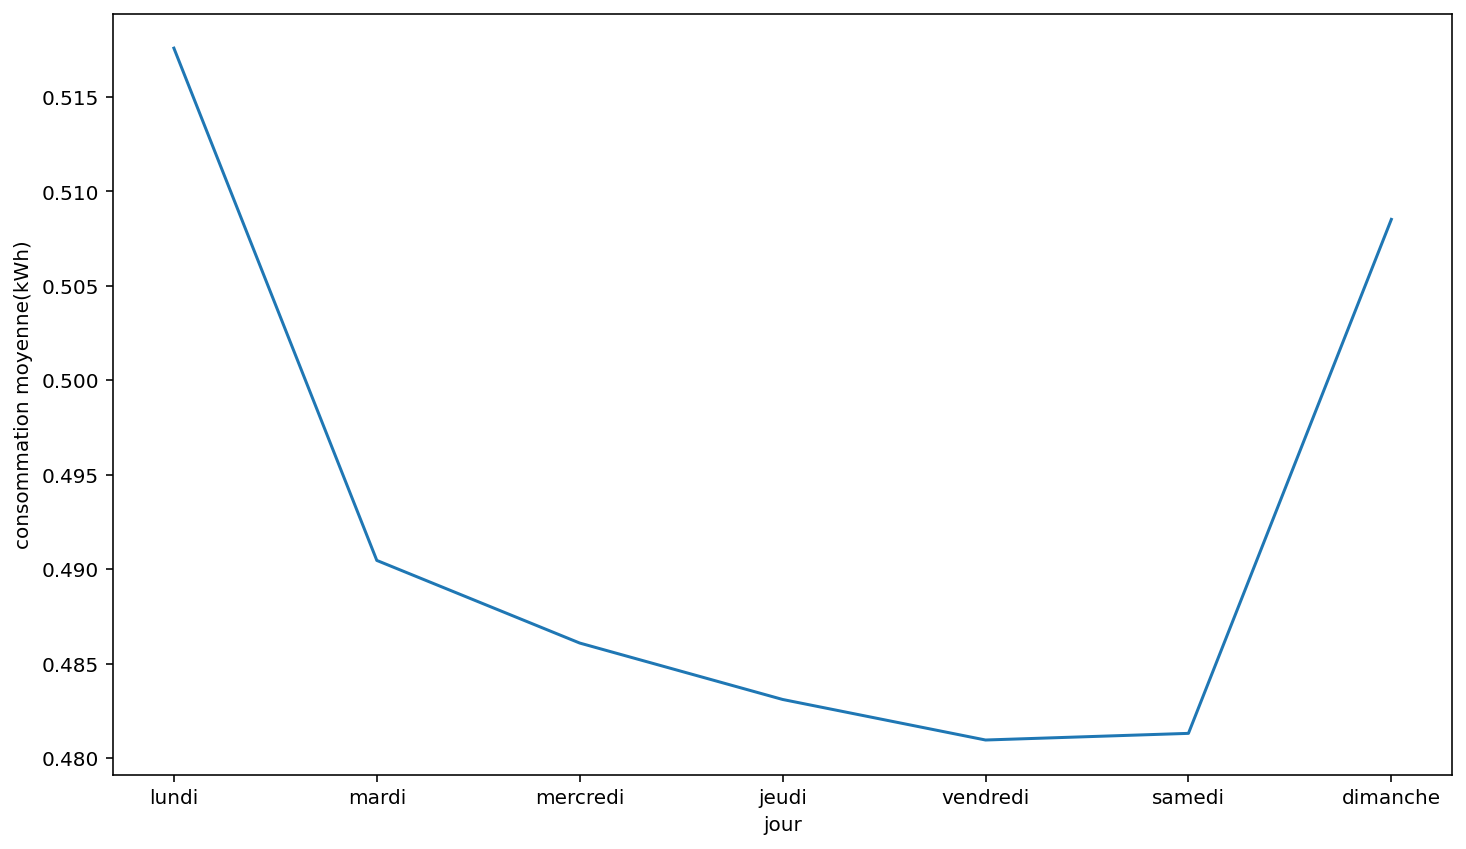

In [5]:
lundi = donnees.query('weekday == 0')['mean']
mardi = donnees.query('weekday == 1')['mean']
mercredi = donnees.query('weekday == 2')['mean']
jeudi = donnees.query('weekday == 3')['mean']
vendredi = donnees.query('weekday == 4')['mean']
samedi = donnees.query('weekday == 5')['mean']
dimanche = donnees.query('weekday == 6')['mean']
jour = [lundi, mardi, mercredi, jeudi, vendredi, samedi, dimanche]
moy = [np.mean(i) for i in jour]
plt.plot(['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche'], moy)
plt.xlabel('jour')
plt.ylabel('consommation moyenne(kWh)')

Consommation en fonction de la température



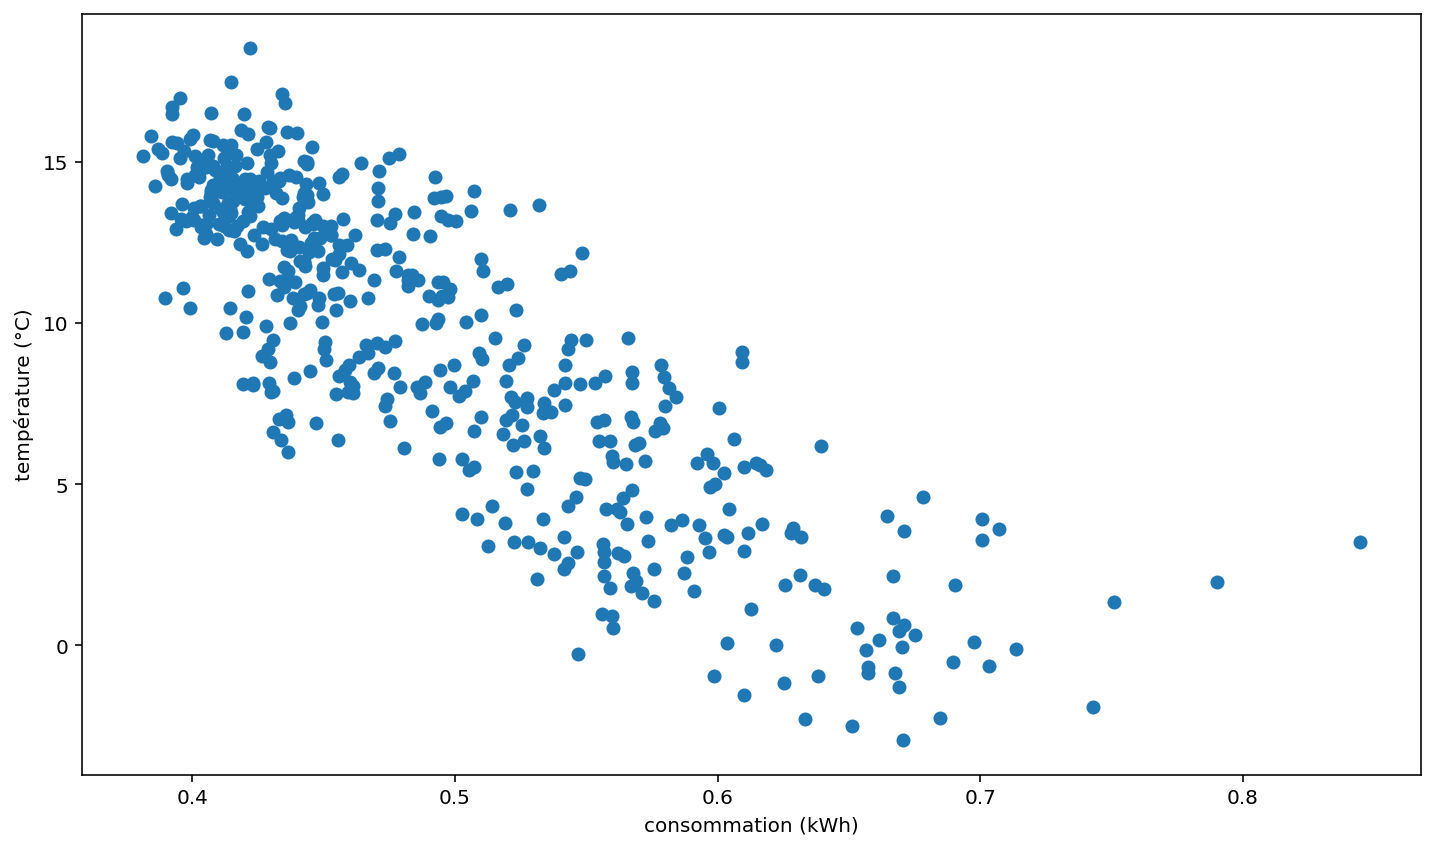

In [6]:
donnees1 = pd.merge(cons,cork)

# Conversion de la colonne 'date' en type datetime
donnees1['date'] = pd.to_datetime(donnees['date'])

#daily_data contient les valeurs moyennes par jour
daily_group = donnees1.resample('D', on='date')
daily_data = daily_group.sum()
daily_data['temp'] = daily_data['temp']/24
daily_data['mean'] = daily_data['mean']/24


plt.scatter(daily_data['mean'],daily_data['temp'])
plt.xlabel('consommation (kWh)')
plt.ylabel('température (°C)')
plt.show()

Consommation en fonction de l'ensoleillement



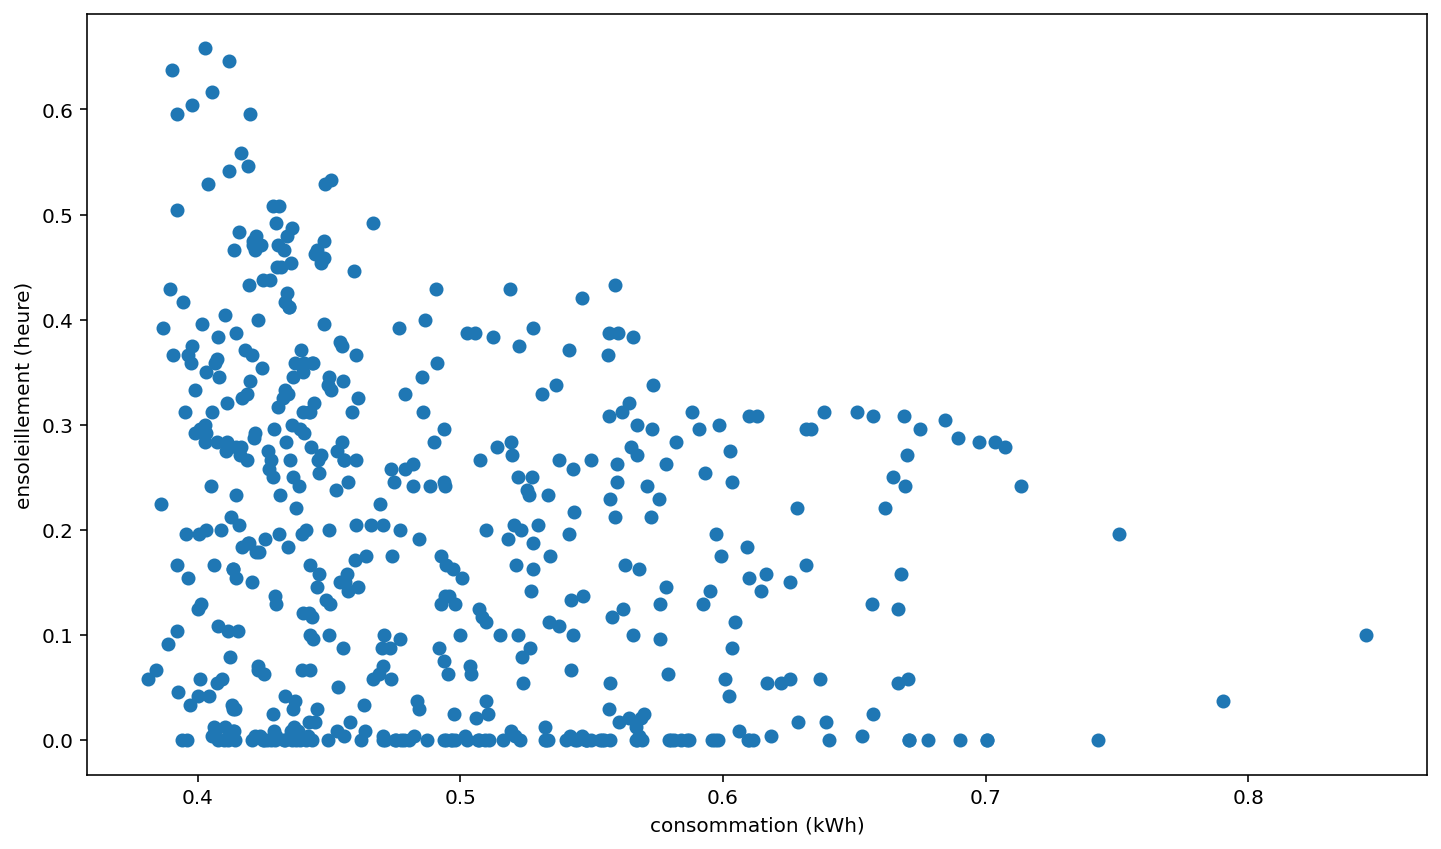

In [7]:
daily_data['sun'] = daily_data['sun']/24



plt.scatter(daily_data['mean'],daily_data['sun'])
plt.xlabel('consommation (kWh)')
plt.ylabel('ensoleillement (heure)')
plt.show()

Consommation en fonction de pression de vapeur


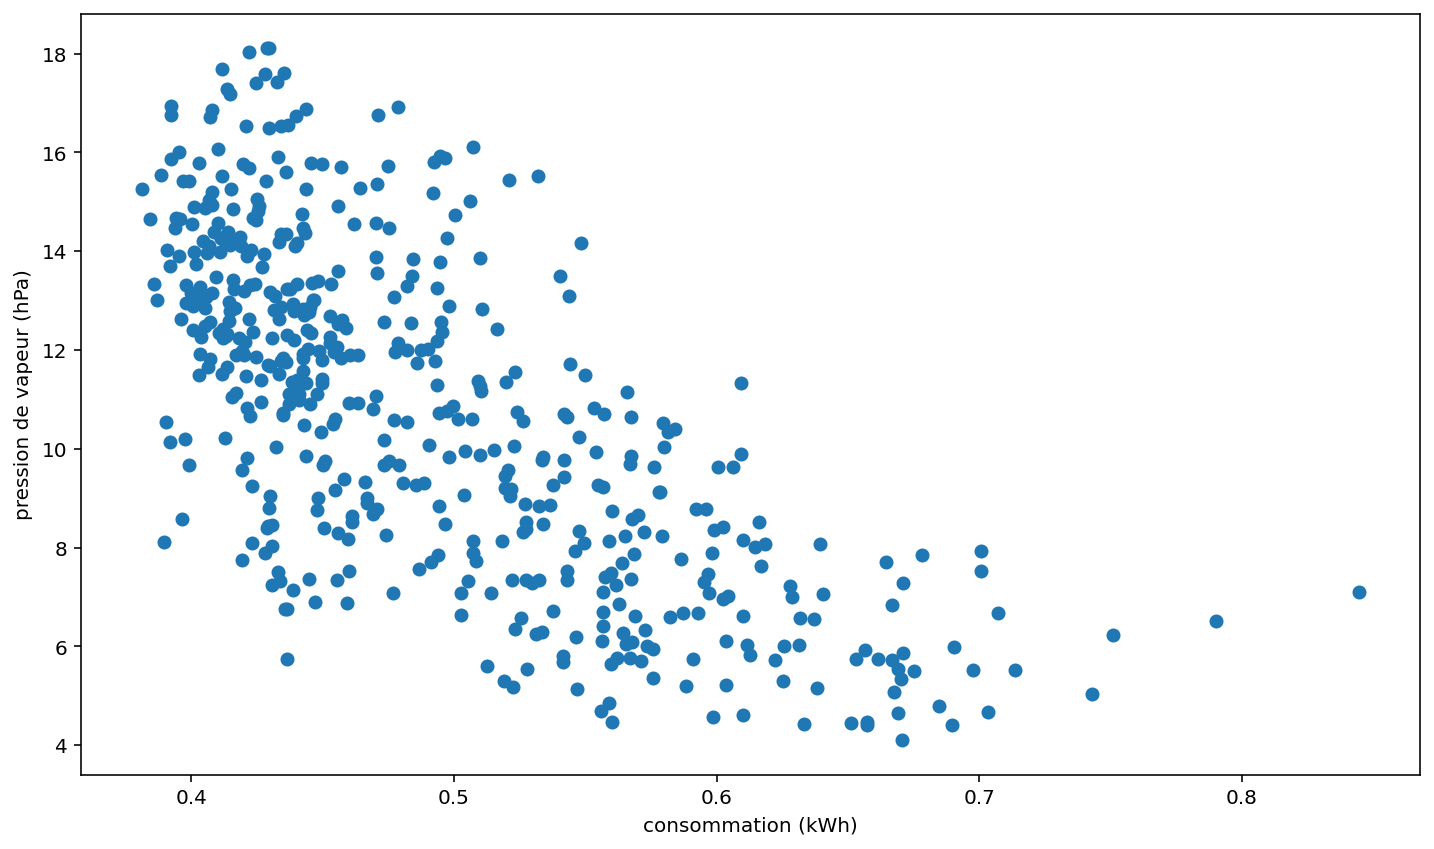

In [8]:
daily_data['vappr'] = daily_data['vappr']/24


plt.scatter(daily_data['mean'],daily_data['vappr'])
plt.xlabel('consommation (kWh)')
plt.ylabel('pression de vapeur (hPa)')
plt.show()

consommation moyenne en fonction de la pluie

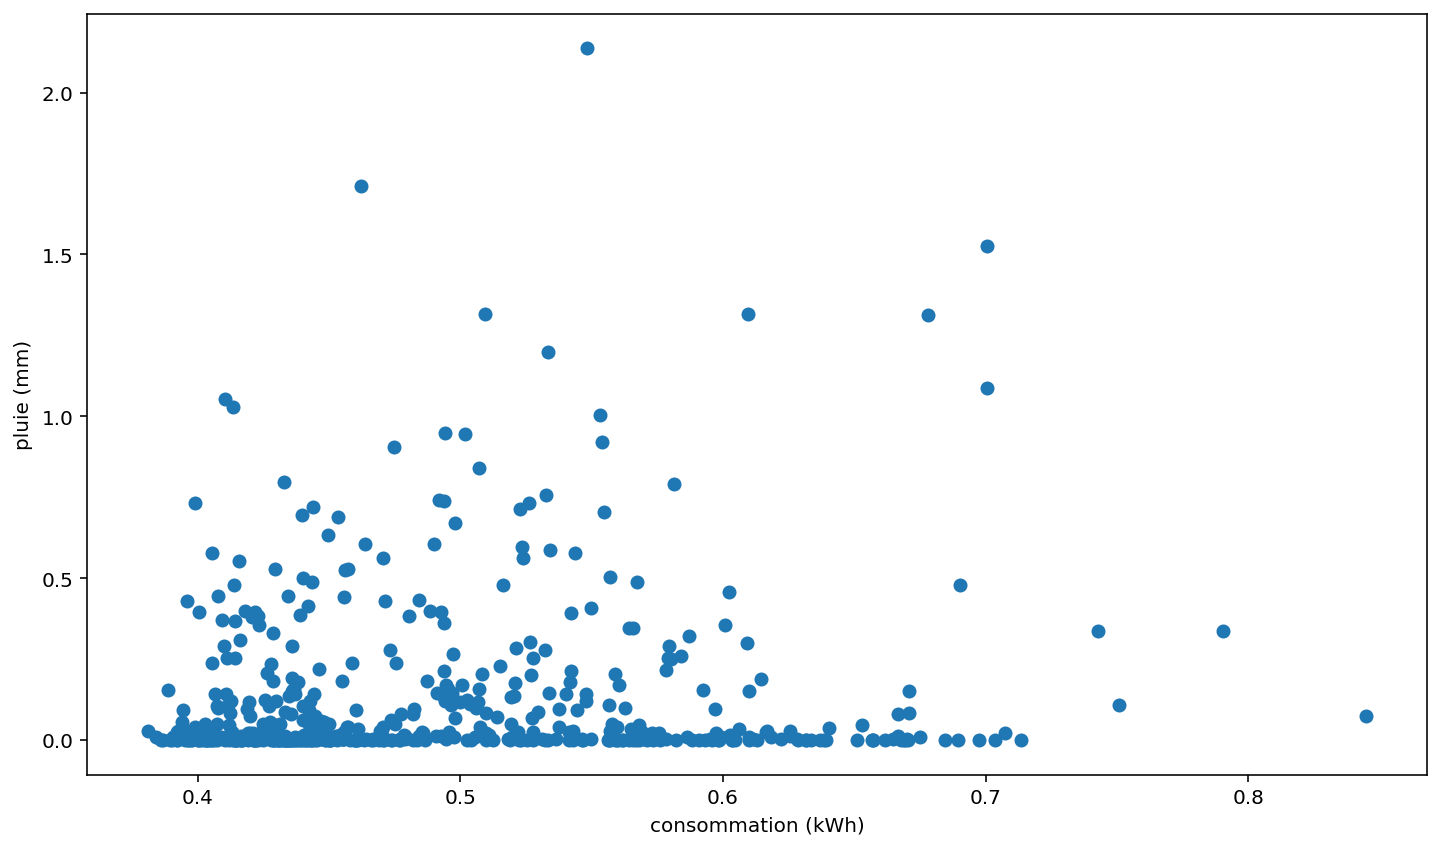

In [9]:
daily_data['rain'] = daily_data['rain']/24
daily_data['mean'] = daily_data['mean']


plt.scatter(daily_data['mean'],daily_data['rain'])
plt.xlabel('consommation (kWh)')
plt.ylabel('pluie (mm)')
plt.show()

Consommation en fonction de l'état général de la météo 


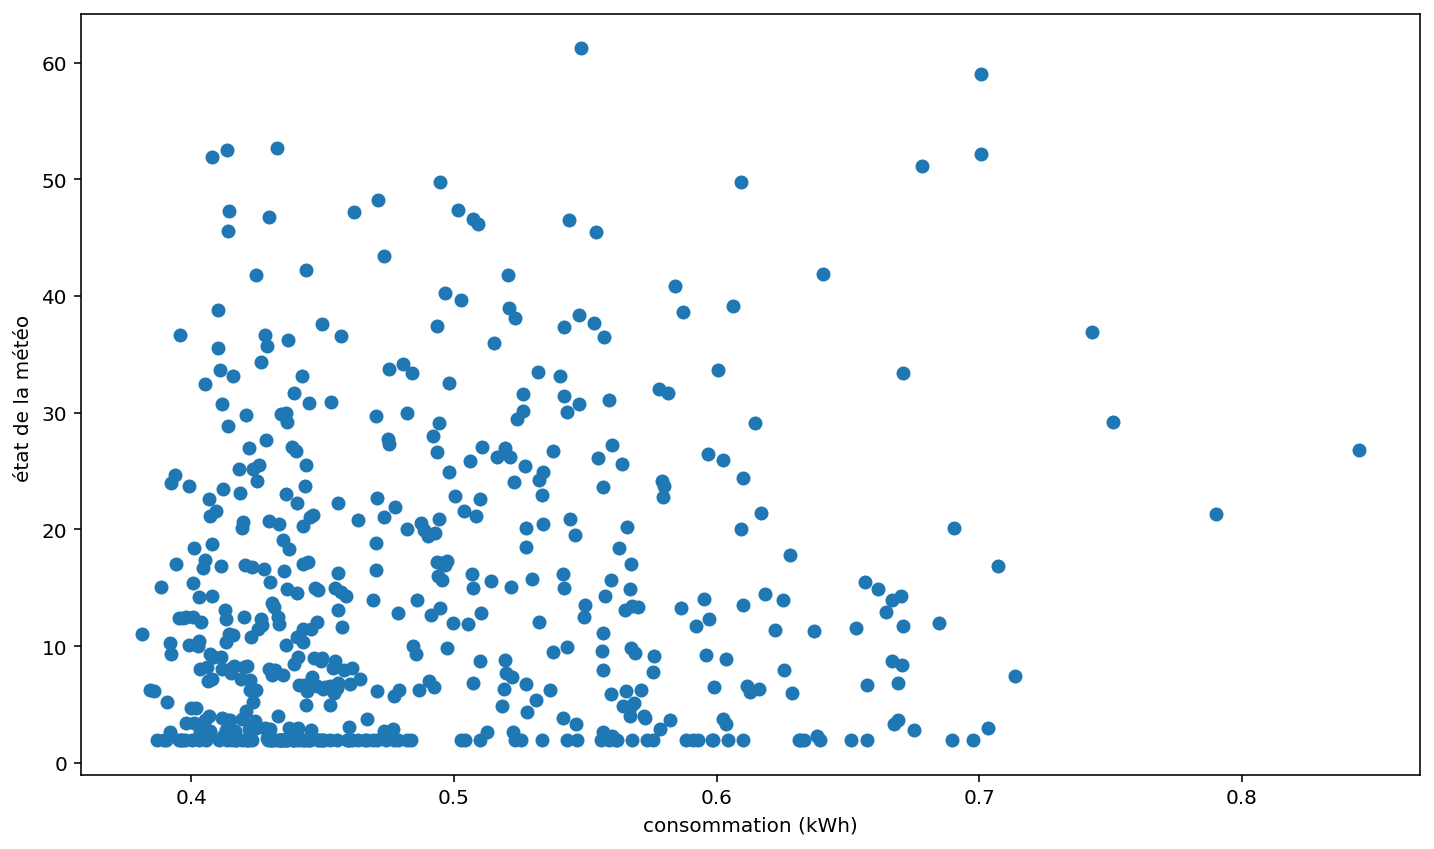

In [10]:
daily_data['ww'] = daily_data['ww']/24
daily_data['mean'] = daily_data['mean']

plt.scatter(daily_data['mean'],daily_data['ww'])
plt.xlabel('consommation (kWh)')
plt.ylabel('état de la météo ')
plt.show()

Consommation en fonction de l'heure

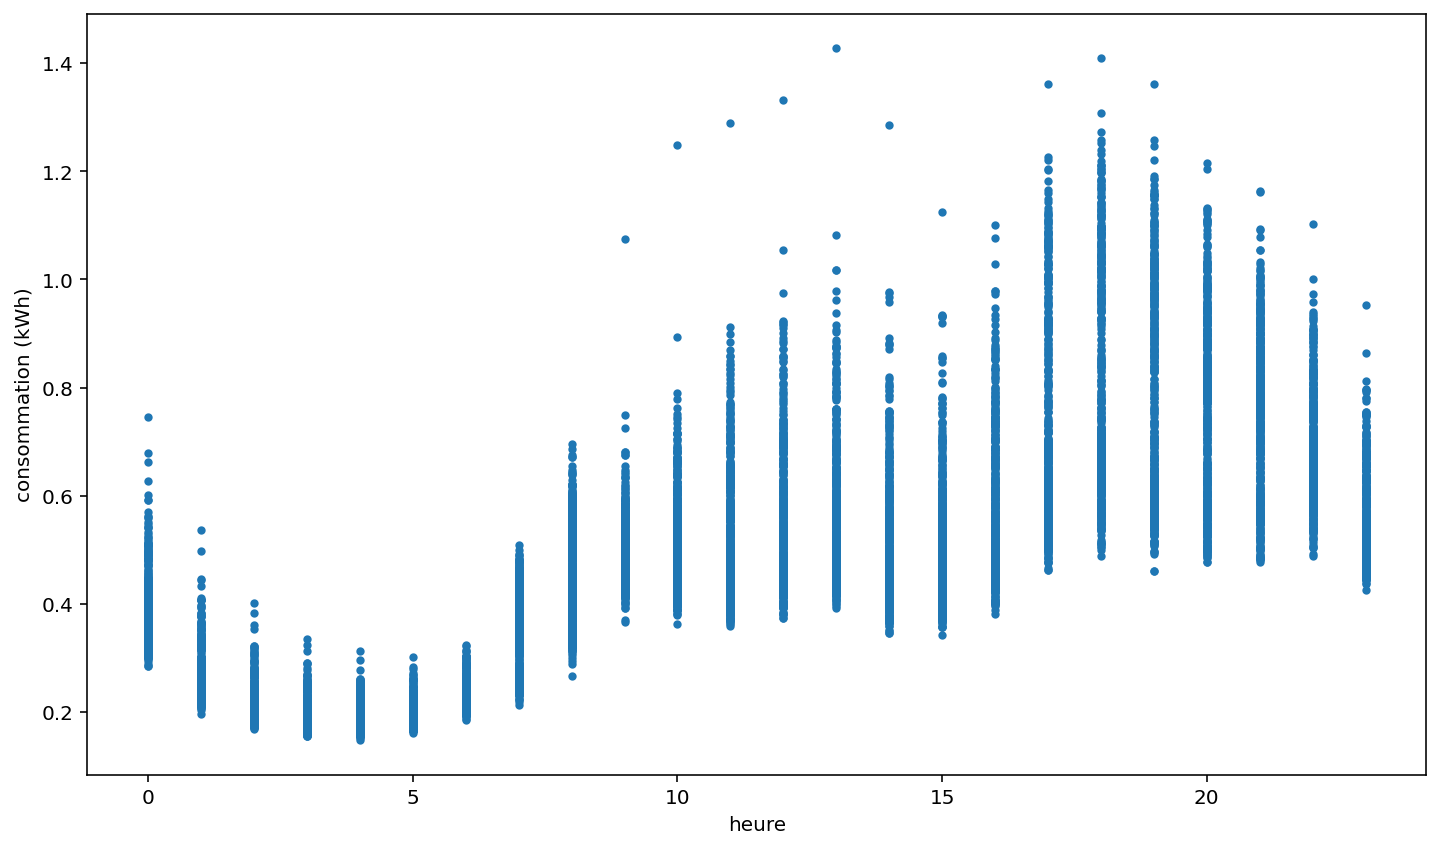

In [11]:
plt.scatter(donnees['Heure'], donnees['mean'],s=10)
plt.xlabel('heure')
plt.ylabel('consommation (kWh)')
plt.show()

Pression de vapeur en fonction de la température moyenne


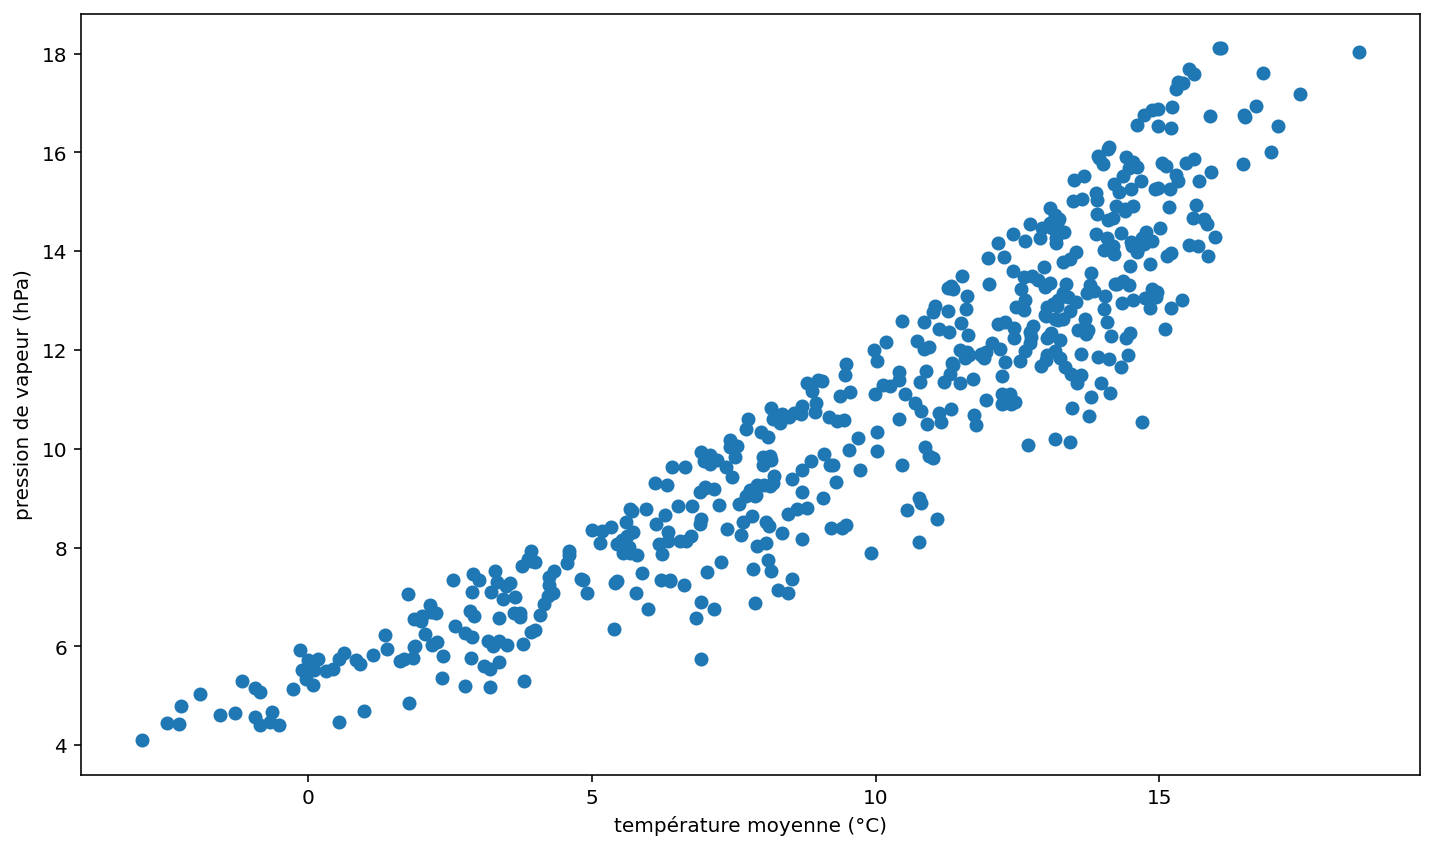

In [12]:
daily_data['vappr'] = daily_data['vappr']
daily_data['temp'] = daily_data['temp']

plt.scatter(daily_data['temp'],daily_data['vappr'])
plt.xlabel('température moyenne (°C)')
plt.ylabel('pression de vapeur (hPa)')
plt.show()

On remarque une corrélation entre la pression de vapeur et la consommation moyenne, mais le graphique précédent montre un lien presque linéaire entre la pression de vapeur et la température. Les informations sont donc redondantes, il n'est pas pertinent d'utiliser les deux variables dans la prédiction car elles apportent la même information. C'est pourquoi seule la température a été choisie. 



On remarque que les données les plus corrélées avec la consommation sont : l'heure, le jour de la semaine, et la température.



# Essai de plusieurs modèles et comparaison de leur score (MAPE) afin de choisir  lequel est le plus adapté à nos données.



Modèle SVM



In [13]:


# enlever les lignes sans consommation
donnees.dropna(inplace=True)


# Création de la matrice des paramètres de prédiction, et du vecteur de consommation 
X = donnees[['Heure','temp','weekday']]

y = donnees['mean']

# Sparation entre données d'entrainement et de test 

X_train = donnees.query('(month > 7 and year == 2009) or (month < 5) or (month > 7 and month < 11 and year == 2010) ')[['Heure','temp','weekday']]
X_test =  donnees.query('month > 10 and year == 2010')[['Heure','temp','weekday']]
Y_train = donnees.query('(month > 7 and year == 2009) or (month < 5) or (month > 7 and month < 11 and year == 2010) ')[['mean']]
Y_test =  donnees.query('month > 10 and year == 2010')[['mean']]




In [14]:
modelSVR = SVR(kernel = 'rbf')
modelSVR.fit(X_train, Y_train)
y_pred = modelSVR.predict(X_test)
score=modelSVR.score(np.array(X_test), np.array(Y_test))
print('Le score est:',score)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le score est: 0.884017795113381


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [15]:
#Calcul du Mean Absolute Percentage Error (pourcentage de la moyenne des erreurs absolues )
mape = np.mean(np.abs((np.array(Y_test).reshape(-1,1) - np.array(y_pred).reshape(-1,1))/Y_test))*100
print('MAPE =',mape)

MAPE = 13.771358401495526


Text(0, 0.5, 'consommation (kWh)')

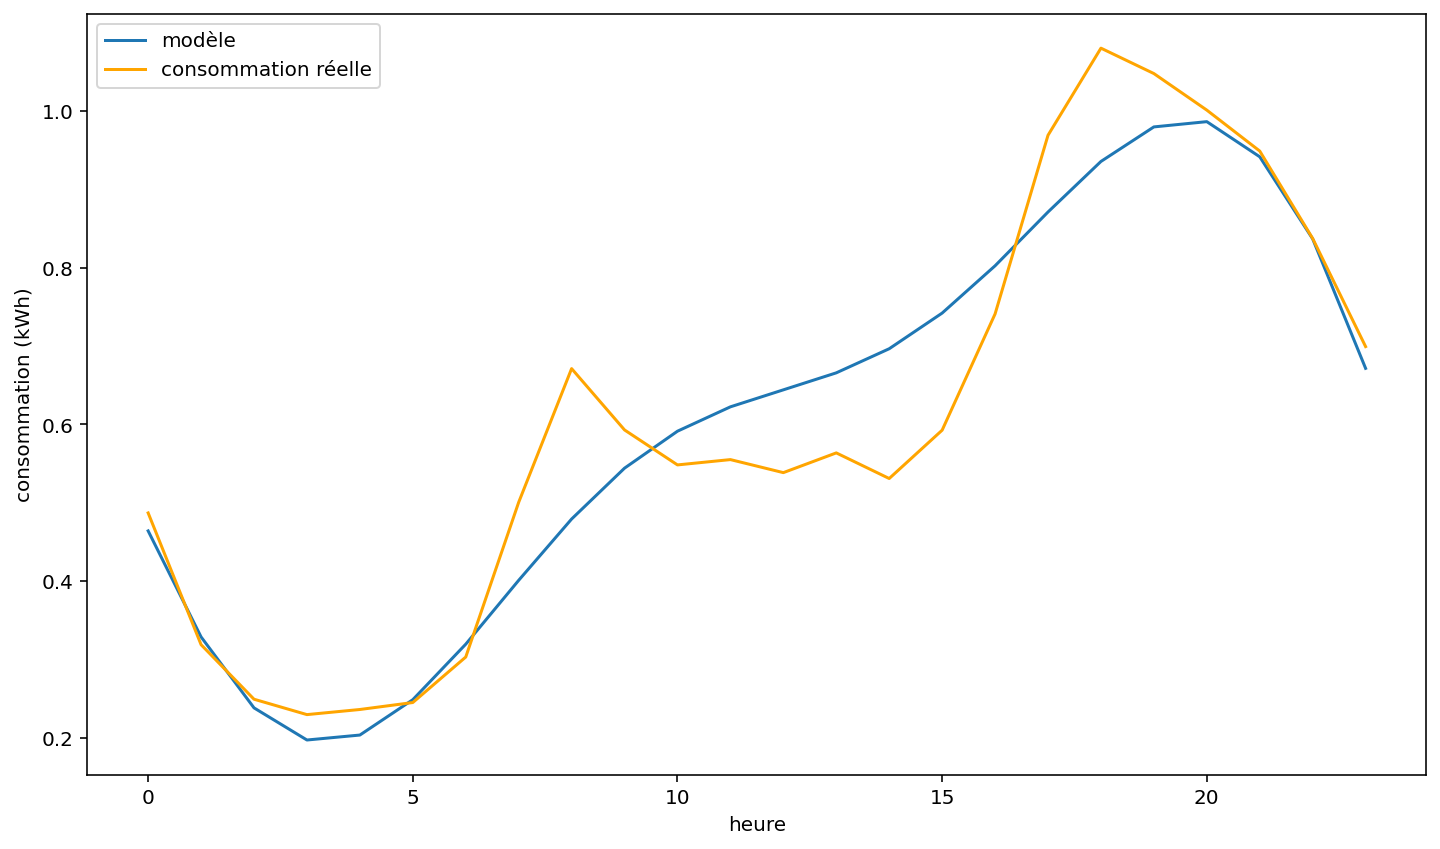

In [16]:
# tracé d'un jour avec la consommation prédite et réelle 
x_pred = donnees.query('index > 12407')
y_predicted = modelSVR.predict(x_pred[['Heure', 'temp','weekday']])
plt.plot(x_pred['Heure'], y_predicted, label='modèle')
plt.plot(x_pred['Heure'], x_pred['mean'], color='orange', label='consommation réelle')
plt.legend()
plt.xlabel('heure')
plt.ylabel('consommation (kWh)')

régression multilinéaire

In [17]:
# Entrainement du modèle linéaire
modelreg = linear_model.LinearRegression()
modelreg.fit(X_train, Y_train)

#calcul des scores 
score_train=modelreg.score(X_train,Y_train)
print('le score du train est :',score_train)
score_test=modelreg.score(X_test,Y_test)
print('le score du test est :',score_test)

Y_predict=modelreg.predict(X_test)

le score du train est : 0.6732751914818398
le score du test est : 0.6754247926851968


In [18]:
#Mean Absolute Percentage Error

mape = np.mean(np.abs((Y_test - Y_predict)/Y_test))*100
print('MAPE =',mape)

MAPE = 28.720734341186073


Text(0, 0.5, 'consommation (kWh)')

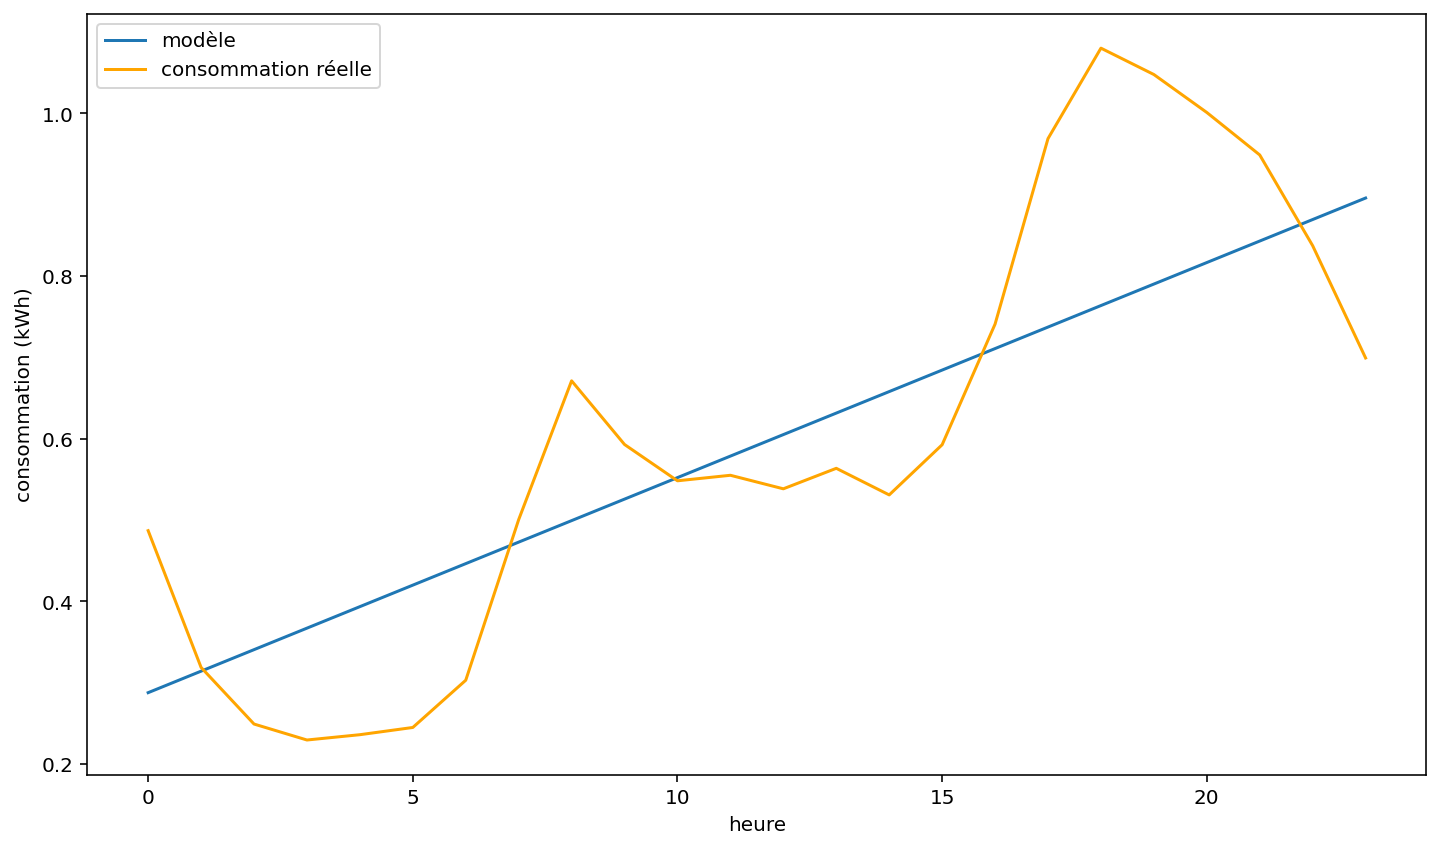

In [19]:
#Tracé de la prédiction du modèle linéaire sur un jour

x_pred = donnees.query('index > 12407')
y_predicted = modelreg.predict(x_pred[['Heure', 'temp','weekday']])
plt.plot(x_pred['Heure'], y_predicted, label='modèle')
plt.plot(x_pred['Heure'], x_pred['mean'], color='orange',label='consommation réelle')
plt.legend()
plt.xlabel('heure')
plt.ylabel('consommation (kWh)')

Régression polynomiale

In [20]:
# Entrainement du modèle de régression polynomiale (polynôme de degrés 9 )
nb_degree=9
modelpol = LinearRegression()
x_transform=PolynomialFeatures(nb_degree).fit_transform(X_train)
x_transform_te=PolynomialFeatures(nb_degree).fit_transform(X_test)
modelpol.fit(x_transform,Y_train)

# Calcul de 'root mean square error' et du score de train 
Y_new = modelpol.predict(x_transform_te)
rmse = np.sqrt(mean_squared_error(Y_test, Y_new))
score_train=r2_score(Y_test,Y_new)
print('score_train : ',score_train)
print('rmse : ',rmse)



score_train :  0.8455708111918845
rmse :  0.1027942999594924


In [21]:
#Mean Absolute Percentage Error
import numpy as np
mape = np.mean(np.abs((Y_test - Y_new)/Y_test))*100
print('MAPE =',mape)

MAPE = 13.701765957773935


modèle KNN

In [2]:

donnees = pd.read_csv("df_vst_group8.csv",decimal='.')

# Conversion de la colonne 'Heures' en type heure
donnees['date'] = pd.to_datetime(donnees['date'])

# Extraction de l'heure, des jours, des jours de semaines, des mois et des années dans des colonnes séparées
donnees['Heure'] = donnees['date'].dt.time.apply(lambda x: x.hour)
donnees['jour'] = donnees['date'].dt.date
donnees['weekday'] = donnees['date'].dt.weekday
donnees['month']= donnees['date'].dt.month
donnees['year'] = donnees['date'].dt.year


# Calcul de la température moyenne par jour
temperature_moyenne = donnees.groupby('jour')['temp'].mean().reset_index()
temperature_moyenne = temperature_moyenne.rename(columns={'temp': 'temp_moyenne'})

# Fusion des températures moyennes avec le dataframe d'origine
donnees_merged = pd.merge(donnees, temperature_moyenne, on='jour')

# Remplacement des valeurs de température par la température moyenne
donnees_merged['temp'] = donnees_merged['temp_moyenne']

# Suppression des colonnes intermédiaires
donnees_merged = donnees_merged.drop([ 'temp_moyenne'], axis=1)

donnees = donnees_merged

# Extraction des jours à prédire 
X_pred = donnees.query('index > 25489')

# Supression des lignes sans consommation  

donnees.dropna(inplace=True)

#Normalisation des données 

max_temp = donnees['temp'].max()
donnees['temp'] = donnees['temp']/max_temp
donnees['Heure'] = donnees['Heure']*8/24 # 8 est un coefficient de poids sur l'heure, et le 24 un coefficient de normalisation 
donnees['weekday'] = donnees['weekday']*2/6 # 2 est un poids et 6 un coefficient de normalisation

# Création de la matrice des paramètres d'entrainement et du vecteur des consommations
X = donnees[['Heure','temp','weekday']]

y = donnees['mean']

# Séparation des données d'entrainement et de test, l'entrainement est sur les mois de Août à Décembre 2009, de Janvier à fin Avril puis de Août à Octobre 2010. Le test est sur les mois de Novembre et les 2 premières semaines de Décembre 2010.

X_train = donnees.query('(month > 7 and year == 2009) or (month < 5) or (month > 7 and month < 11 and year == 2010) ')[['Heure','temp','weekday']]
X_test =  donnees.query('month > 10 and year == 2010')[['Heure','temp','weekday']]
Y_train = donnees.query('(month > 7 and year == 2009) or (month < 5) or (month > 7 and month < 11 and year == 2010) ')[['mean']]
Y_test =  donnees.query('month > 10 and year == 2010')[['mean']]

In [3]:

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[25,26,27,29,30,31,32,33,34,35,36,37,38,39,40,45,47,50,59,60,61,63,67]}


# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
     
)
# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train, Y_train)



GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [18, 19, 20, 22, 23, 25, 26, 27, 29, 30,
                                         31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                                         45, 47, 50, 59, 60, 61]})

In [4]:
# Choix de l'hyperparamètre optimisé. 

nb_neighbors = clf.best_params_['n_neighbors']
print('nombre de voisins pris en compte :', nb_neighbors)

#Entrainement du modèle avec kNN

model = KNeighborsRegressor(nb_neighbors, weights='distance')

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('le score est : ',model.score(X_test, Y_test))

nombre de voisins pris en compte : 60
le score est :  0.9250605878463842


In [25]:
#Mean Absolute Percentage Error

mape = np.mean(np.abs((Y_test - Y_pred)/Y_test))*100
print('MAPE =',mape)



MAPE = 9.716377953056817


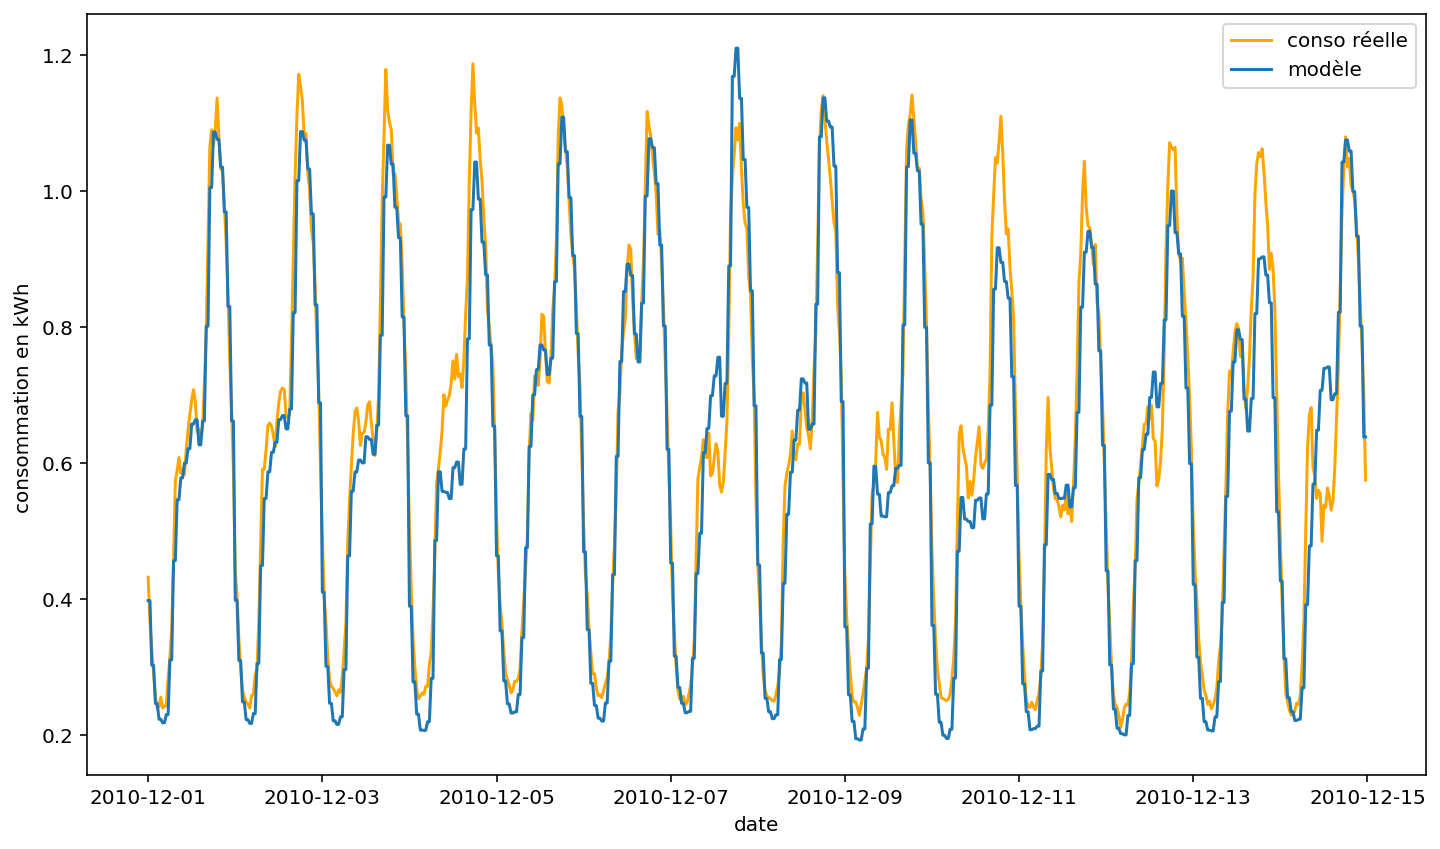

In [26]:
x_pred = donnees.query('month == 12 and year == 2010')
y_predicted = model.predict(x_pred[['Heure', 'temp', 'weekday']])
plt.plot(x_pred['date'], x_pred['mean'], color='orange',label='conso réelle')
plt.plot(x_pred['date'], y_predicted,label='modèle')
plt.legend()
plt.xlabel('date')
plt.ylabel('consommation en kWh ')
plt.show()

# Prédiction des derniers jours de décembre



In [27]:
#importation des données
data = pd.read_csv('df_vst_group8.csv') 

#ajout des informations nécessaires
data['date'] = pd.to_datetime(data['date'])
data['Heure'] = data['date'].dt.time.apply(lambda x: x.hour)
data['jour'] = data['date'].dt.date
data['weekday'] = data['date'].dt.weekday

#selection des donnéees sur la période à prévoir
to_predict = data[data['mean'].isna()]

# Calcul de la température moyenne par jour et remplacement des valeurs de température par la température moyenne
temperature_moyenne = to_predict.groupby('jour')['temp'].mean().reset_index()
temperature_moyenne = temperature_moyenne.rename(columns={'temp': 'temp_moyenne'})
donnees_merged = pd.merge(to_predict, temperature_moyenne, on='jour')
donnees_merged['temp'] = donnees_merged['temp_moyenne']
donnees_merged = donnees_merged.drop([ 'temp_moyenne'], axis=1)

to_predict = donnees_merged


#normalisation des données et coefficientation 
max_temp = to_predict['temp'].max()
to_predict['temp'] = to_predict['temp']/max_temp
to_predict['Heure'] = to_predict['Heure']*8/24
to_predict['weekday'] = to_predict['weekday']*2/6

#prediction de la consommation
prediction = model.predict(to_predict[['Heure', 'temp', 'weekday']])
pred = pd.DataFrame(prediction, columns = ['mean'])

#exportation de la consommation électrique sur la période à prévoir au format csv
pred.to_csv('pred.csv')



NameError: name 'np' is not defined

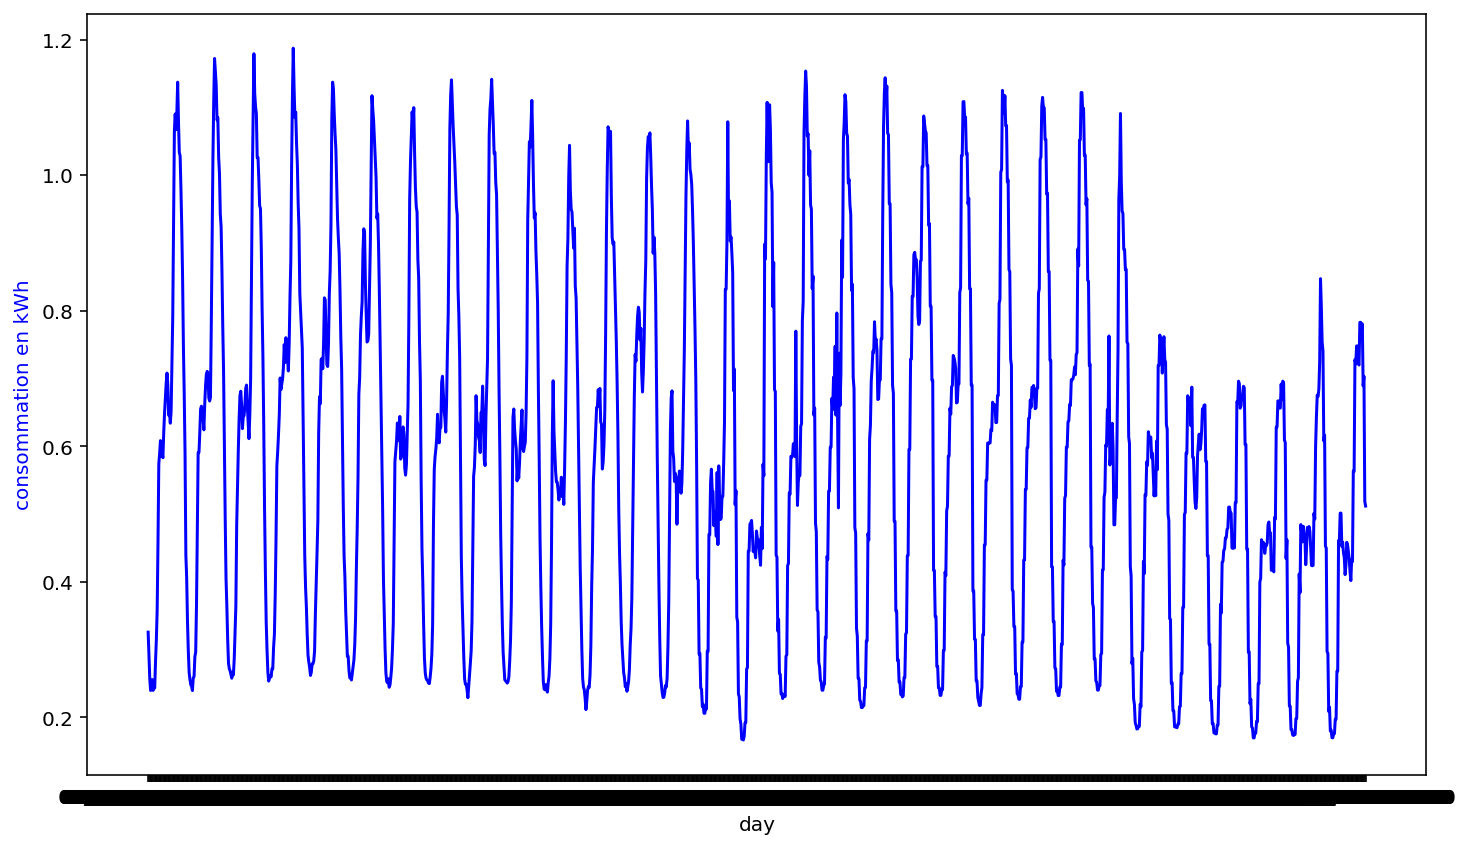

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('prediction_groupe_8.csv', sep=';', decimal='.')
dec = data.query('index > 24193')

fig, ax1 = plt.subplots()


ax1.set_xlabel('day')
ax1.set_ylabel('consommation en kWh', color='blue')
ax1.plot(dec['date'], dec['mean'], color='blue')
ax1.xaxis.set_ticks(np.arange(24193, 25681, 48))
ax1.tick_params(axis='y', l5abelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('temperature en C°', color='orange')  # we already handled the x-label with ax1
ax2.plot(dec['date'], dec['temp'], color='orange')
ax2.xaxis.set_ticks(np.arange(24193, 25681, 48))
ax2.tick_params(axis='y', labelcolor='orange')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

On remarque que les prédictions du modèle sont bien en accord avec l'évolution de la température \(baisse de la consommation lorsque la température augmente\).
